In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import pandas as pd
import numpy as np
import pickle

import re
from nltk.tokenize import word_tokenize

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [35]:
# preprocessing functions

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

def get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Load Embeddings
def load_glove(word_index):
    EMBEDDING_FILE = "/content/drive/MyDrive/Grammar_Exercises/data/learner_level/glove6B/glove.6B.300d.txt"
    
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding='utf-8'))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [36]:
tatoeba_df = pd.read_pickle('/content/drive/MyDrive/Grammar_Exercises/data/learner_level/tatoeba/tatoeba_level_annotated_sentences.pkl')
sentences_corpus = tatoeba_df

In [37]:
count_df = sentences_corpus[['Sentences','Labels']].groupby('Labels').aggregate({'Sentences':'count'}).reset_index().sort_values('Sentences',ascending=False)
count_df.head()

,Labels,Sentences
0,A,106682
1,B,82270
2,C,69983


In [38]:
# obtain the max length of our sentences in order to compromise the model in such a length
sentences_corpus['len'] = sentences_corpus['Sentences'].apply(lambda s : len(s))
max_len = sentences_corpus.len.tolist()
maxlen = max(max_len)

# hyperparameters

# how big is each word vector
embed_size = 300 

# how many unique words to use (i.e num rows in embedding vector)
max_features = 120000 

# max number of words in a sentence to use for padding
maxlen = maxlen 

# how many samples to process at once
batch_size = 128

# how many times to iterate over all samples
n_epochs = 7

# learning rate
learn_rate = 0.001

# Number of K-fold Splits
n_splits = 5 

# network hidden size
hid_size = 64

# dropout 
dropout = 0.8

SEED = 10
debug = 0

# this is a list of expanded abbreviations
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

contractions, contractions_re = get_contractions(contraction_dict)

# Balance the data according to the minimum class value
num_of_levels = 69900
shuffled = sentences_corpus.reindex(np.random.permutation(sentences_corpus.index))

A = shuffled[shuffled['Labels'] == 'A'][:num_of_levels]
B = shuffled[shuffled['Labels'] == 'B'][:num_of_levels]
C = shuffled[shuffled['Labels'] == 'C'][:num_of_levels]

balanced_df = pd.concat([A,B,C], ignore_index=True)

#Shuffle the dataset
balanced_df = balanced_df.reindex(np.random.permutation(balanced_df.index))
balanced_df.reset_index(drop=True)

#  lower the text
balanced_df["Sentences"] = balanced_df["Sentences"].apply(lambda x: x.lower())

# Clean the text
balanced_df["Sentences"] = balanced_df["Sentences"].apply(lambda x: clean_text(x))

# Clean numbers
balanced_df["Sentences"] = balanced_df["Sentences"].apply(lambda x: clean_numbers(x))

# Clean Contractions
balanced_df["Sentences"] = balanced_df["Sentences"].apply(lambda x: replace_contractions(x))

In [39]:
train_X, test_X, train_y, test_y = train_test_split(balanced_df['Sentences'], balanced_df['Labels'],
                                                    stratify=balanced_df['Labels'], 
                                                    test_size=0.25)

test_sentences = test_X
test_labels = test_y

print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

# missing entries in the embedding are set using np.random.normal so we have to seed here too
if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

Train shape :  (157275,)
Test shape :  (52425,)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = hid_size
        drp = dropout
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learn_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):

    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/7 	 loss=82.0243 	 val_loss=44.0841  	 val_acc=0.8650
Epoch 2/7 	 loss=48.7295 	 val_loss=33.4658  	 val_acc=0.9049
Epoch 3/7 	 loss=38.4958 	 val_loss=29.5426  	 val_acc=0.9212
Epoch 4/7 	 loss=32.1223 	 val_loss=25.5982  	 val_acc=0.9328
Epoch 5/7 	 loss=28.1807 	 val_loss=25.9963  	 val_acc=0.9363
Epoch 6/7 	 loss=25.4100 	 val_loss=23.6384  	 val_acc=0.9428
Epoch 7/7 	 loss=22.2757 	 val_loss=22.6410  	 val_acc=0.9473


In [103]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

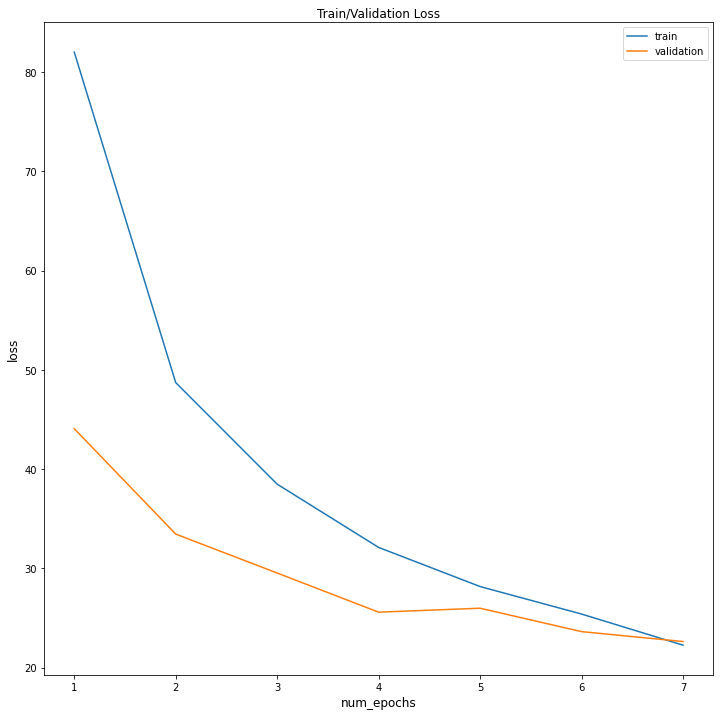

In [106]:
import matplotlib.pyplot as plt

plot_graph(n_epochs)

In [44]:
# function for the final prediction
def predict_single(x):
      
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = torch.tensor(x, dtype=torch.long).to(device)

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

# Classification metrics on the trained model

In [90]:
# retrieve the predictions for each sentence in the test set
test_labels_predicted = []
for x in test_sentences:
  test_labels_predicted.append(predict_single(x))

# we need the true labels and the predicted labels
test_labels = test_y
test_labels_l = test_labels.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [91]:
# convert both true and predicted labels to comparable digits
for index, elem in enumerate(test_labels_predicted):
  if elem == 'A':
    test_labels_predicted[index] = 0
  elif elem == 'B':
    test_labels_predicted[index] = 1
  elif elem == 'C':
    test_labels_predicted[index] = 2

In [92]:
from sklearn.metrics import classification_report

print('\nClassification Report\n')
print(classification_report(test_labels_l, test_labels_predicted, target_names=['Begginer', 'Intermediate', 'Advance']))


Classification Report

              precision    recall  f1-score   support

    Begginer       0.94      0.96      0.95     17475
Intermediate       0.94      0.93      0.93     17475
     Advance       0.97      0.96      0.96     17475

    accuracy                           0.95     52425
   macro avg       0.95      0.95      0.95     52425
weighted avg       0.95      0.95      0.95     52425



# Further evaluation on existing corpora

## The OneStopEnglish corpus

In [93]:
import os
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [94]:
with open ("/content/drive/MyDrive/Grammar_Exercises/data/learner_level/OneStopEnglish/OneStopEnglishCorpus.txt", encoding='utf-8') as f:
    # each triple is split with those asterisks     
    data = f.read().split("**********")
    
    leveled_sentences = []
    for line in data:
        try:
            # each line corresponds to one out of three levels             
            advance = [line.strip().split("\n")[0],'C']
            intermediate = [line.strip().split("\n")[1],'B']
            elementary = [line.strip().split("\n")[2],'A']
        except IndexError:
            print("index error")
            pass
    
        leveled_sentences.append(elementary)
        leveled_sentences.append(intermediate)
        leveled_sentences.append(advance)
    
    # last line of the file is the last asterisks     
    leveled_sentences = leveled_sentences[:-1]

df = pd.DataFrame(leveled_sentences, columns=["Sentence", "Level"])

# dropping duplicate values, because some sentences were kept the same among levels
df.drop_duplicates(subset ="Sentence", keep = False, inplace = True)

# remove NULL Values from data if any
onestop_df = df[pd.notnull(df['Sentence'])]

onestop_df.sample(frac=1)

index error


,Sentence,Level
1660,"According to Boer , the villages are not for â...",B
719,"â€œ Either the mine must stop digging , creati...",C
2124,But weâ€™re going to have to look at these oth...,A
3566,"Ground into flour and used to make injera , th...",C
874,â€œ Iâ€™m really excited by the potential it h...,B
...,...,...
1310,"Pollution , traffic and loss of green spaces a...",C
836,"A little later , the football club secretary a...",C
2957,But his passing will also be keenly felt by pe...,C
3279,When he was asked if he felt more comfortable ...,A


In [95]:
onestop_pred = []
onestop_wrong_predicted = []

for i, row in onestop_df.iterrows():

  prediction = predict_single(row['Sentence'])
  
  # this is the predicted label
  onestop_pred.append(predict_single(row['Sentence']))

  # we also keep the wrong predictions to perform a qualitative analysis
  if not prediction == row['Level']:
    onestop_wrong_predicted.append([prediction, row['Level'], row['Sentence']])

# this is the true labels
onestop_true_pred = onestop_df['Level'].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [96]:
from sklearn.metrics import classification_report

print('\nClassification Report\n')
print(classification_report(onestop_true_pred, onestop_pred, target_names=['Begginer', 'Intermediate', 'Advance']))


Classification Report

              precision    recall  f1-score   support

    Begginer       0.49      0.09      0.15      1384
Intermediate       0.35      0.49      0.41      1403
     Advance       0.37      0.53      0.44      1370

    accuracy                           0.37      4157
   macro avg       0.40      0.37      0.33      4157
weighted avg       0.40      0.37      0.33      4157



In [97]:
for elem in onestop_wrong_predicted:
  print(elem)

['C', 'A', 'British and Dutch researchers develop new form of lie-detector test Ewen MacAskill , defence and security correspondent January , 2015 Police and intelligence agencies around the world have , for almost 100 years , used the polygraph , a lie-detector test , to help catch criminals and spies .']
['B', 'C', 'British and Dutch researchers develop new form of lie-detector test Polygraph replacement could be in use in police stations around the world within a decade Ewen MacAskill , defence and security correspondent January , 2015 Police and intelligence agencies around the world have , for almost 100 years , relied on lie detectors to help convict criminals or unearth spies and traitors . ']
['A', 'B', 'The polygraph is widely used in the US in criminal cases and for security clearance for the FBI and CIA but is much less popular in Europe . ']
['B', 'C', 'The polygraph is widely used in the US in criminal and other cases and for security clearance for the FBI and CIA but is m

## The Score corpus

In [98]:
score_corpus = pd.read_csv("/content/drive/MyDrive/Grammar_Exercises/data/learner_level/Score_Corpus/score_data.csv", sep=',', encoding = 'latin-1')

# keep only the sentences
del score_corpus['category']
del score_corpus['subcategory']
del score_corpus['keyword']

# drop null values
score_corpus.dropna(subset = ["level"], inplace=True)

# drop duplicate values
score_corpus.drop_duplicates(subset ="example", keep = False, inplace = True)

# some targeted words in each sentence were indicated as inside of brackets 
score_corpus['example'] = score_corpus['example'].apply(lambda s : s.replace("{","").replace("}",""))

# shuffle it
score_corpus = score_corpus.sample(frac=1).reset_index(drop=True)

In [99]:
keep = []
for i, row in score_corpus.iterrows():
  if row['level'] == 'beginner':
    row['level'] = 'A'
  elif row['level'] == 'intermediate':
    row['level'] = 'B'
  elif row['level'] == 'advanced':
    row['level'] = 'C'

In [100]:
score_pred = []
score_wrong_predicted = []

for i, row in score_corpus.iterrows():

  prediction = predict_single(row['example'])

  # this is the predicted label
  score_pred.append(predict_single(row['example']))

  # we also keep the wrong predictions to perform a qualitative analysis
  if not prediction == row['level']:
    score_wrong_predicted.append([prediction, row['level'], row['example']])

# this is the true labels
score_true_pred = score_corpus['level'].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [101]:
from sklearn.metrics import classification_report

print('\nClassification Report\n')
print(classification_report(score_true_pred, score_pred, target_names=['Begginer', 'Intermediate', 'Advance']))


Classification Report

              precision    recall  f1-score   support

    Begginer       0.70      0.47      0.57      8909
Intermediate       0.23      0.35      0.28      3504
     Advance       0.30      0.40      0.34      3197

    accuracy                           0.43     15610
   macro avg       0.41      0.41      0.40     15610
weighted avg       0.51      0.43      0.46     15610



In [102]:
for elem in score_wrong_predicted:
  print(elem)

Streaming output truncated to the last 5000 lines.
['C', 'A', "He can't decide what to buy."]
['C', 'B', 'Nothing in this movie makes sense.']
['C', 'A', 'My sister lives in Florida.']
['A', 'B', 'I wish he was not in charge of the school.']
['C', 'A', 'Do you know any famous gardeners?']
['B', 'C', 'The banks have increasingly come under fire for the bonuses paid to executives after the taxpayer-led bailouts.']
['B', 'A', 'Emily looked delighted when her mother brought doughnuts.']
['A', 'C', 'The American School in Japan is usually called ASIJ.']
['C', 'A', 'Take the number 35 bus to Shibuya.']
['C', 'B', 'If he was going to be late, he would have called.']
['C', 'A', 'Please undress from the waist down.']
['B', 'C', 'There will be a very tense atmosphere between Japan, Korea, and China because of the dispute over the island.']
['C', 'A', 'I like iced tea.']
['C', 'A', 'She loved picking grapes off the vines.']
['B', 'C', 'They hired someone to come in every day to water the plants a

## Parse with difficulty level the Wikipedia corpus

In [ ]:
wiki_corpus = pd.read_pickle('/content/drive/MyDrive/Grammar_Exercises/data/clean_results/wikipedia_sentences_parsed_selection.pkl')

In [ ]:
wiki_corpus

,Sentence,Tokens,Lemma,Upos,Xpos,Dependency,Features,id,Head
0,History is the study of past events.,"[History, is, the, study, of, past, events, .]","[history, be, the, study, of, past, event, .]","[NOUN, AUX, DET, NOUN, ADP, ADJ, NOUN, PUNCT]","[NN, VBZ, DT, NN, IN, JJ, NNS, .]","[(study, nsubj), (study, cop), (study, det), (...","[Number=Sing, Mood=Ind|Number=Sing|Person=3|Te...","[1, 2, 3, 4, 5, 6, 7, 8]","[4, 4, 4, 0, 7, 7, 4, 4]"
1,A person who studies history is called a histo...,"[A, person, who, studies, history, is, called,...","[a, person, who, study, history, be, call, a, ...","[DET, NOUN, PRON, VERB, NOUN, AUX, VERB, DET, ...","[DT, NN, WP, VBZ, NN, VBZ, VBN, DT, NN, .]","[(person, det), (called, nsubj:pass), (studies...","[Definite=Ind|PronType=Art, Number=Sing, PronT...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[2, 7, 4, 2, 4, 7, 0, 9, 7, 7]"
2,A person who studies pre-history and history t...,"[A, person, who, studies, pre-history, and, hi...","[a, person, who, study, pre-history, and, hist...","[DET, NOUN, PRON, VERB, NOUN, CCONJ, NOUN, ADP...","[DT, NN, WP, VBZ, NN, CC, NN, IN, NNS, VBN, IN...","[(person, det), (called, nsubj:pass), (studies...","[Definite=Ind|PronType=Art, Number=Sing, PronT...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 16, 4, 2, 4, 7, 5, 9, 4, 9, 10, 14, 14, 10..."
3,A person who studies mankind and society is ca...,"[A, person, who, studies, mankind, and, societ...","[a, person, who, study, mankind, and, society,...","[DET, NOUN, PRON, VERB, NOUN, CCONJ, NOUN, AUX...","[DT, NN, WP, VBZ, NN, CC, NN, VBZ, VBN, DT, NN...","[(person, det), (called, nsubj:pass), (studies...","[Definite=Ind|PronType=Art, Number=Sing, PronT...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[2, 9, 4, 2, 4, 7, 5, 9, 0, 11, 9, 9]"
5,People can learn about the past by talking to ...,"[People, can, learn, about, the, past, by, tal...","[people, can, learn, about, the, past, by, tal...","[NOUN, AUX, VERB, ADP, DET, NOUN, SCONJ, VERB,...","[NNS, MD, VB, IN, DT, NN, IN, VBG, IN, NNS, WP...","[(learn, nsubj), (learn, aux), (root, root), (...","[Number=Plur, VerbForm=Fin, VerbForm=Inf, _, D...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 3, 0, 6, 6, 3, 8, 3, 10, 8, 12, 10, 12, 15..."
...,...,...,...,...,...,...,...,...,...
195866,"George Reeves , was an American actor.","[George, Reeves, ,, was, an, American, actor, .]","[george, reeves, ,, be, a, American, actor, .]","[PROPN, PROPN, PUNCT, AUX, DET, ADJ, NOUN, PUNCT]","[NNP, NNP, ,, VBD, DT, JJ, NN, .]","[(actor, nsubj), (george, flat), (george, punc...","[Number=Sing, Number=Sing, _, Mood=Ind|Number=...","[1, 2, 3, 4, 5, 6, 7, 8]","[7, 1, 1, 7, 7, 7, 0, 7]"
195867,He was TV's original superman.,"[He, was, TV, 's, original, superman, .]","[he, be, tv, 's, original, superman, .]","[PRON, AUX, NOUN, PART, ADJ, NOUN, PUNCT]","[PRP, VBD, NN, POS, JJ, NN, .]","[(superman, nsubj), (superman, cop), (superman...",[Case=Nom|Gender=Masc|Number=Sing|Person=3|Pro...,"[1, 2, 3, 4, 5, 6, 7]","[6, 6, 6, 3, 6, 0, 6]"
195868,His death at age 45 from a gunshot remains a c...,"[His, death, at, age, 45, from, a, gunshot, re...","[he, death, at, age, 45, from, a, gunshot, rem...","[PRON, NOUN, ADP, NOUN, NUM, ADP, DET, NOUN, V...","[PRP$, NN, IN, NN, CD, IN, DT, NN, VBZ, DT, JJ...","[(death, nmod:poss), (remains, nsubj), (age, c...",[Gender=Masc|Number=Sing|Person=3|Poss=Yes|Pro...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[2, 9, 4, 2, 4, 8, 8, 2, 0, 12, 12, 9, 9]"
195870,When he was fifteen he moved to California wit...,"[When, he, was, fifteen, he, moved, to, Califo...","[when, he, be, fifteen, he, move, to, californ...","[SCONJ, PRON, AUX, NUM, PRON, VERB, ADP, PROPN...","[WRB, PRP, VBD, CD, PRP, VBD, IN, NNP, IN, PRP...","[(fifteen, mark), (fifteen, nsubj), (fifteen, ...","[PronType=Int, Case=Nom|Gender=Masc|Number=Sin...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[4, 4, 4, 6, 6, 0, 8, 6, 11, 11, 6, 11, 6]"


In [ ]:
wiki_level_predictions = []
for i, row in wiki_corpus.iterrows():
  wiki_level_predictions.append(predict_single(row['Sentence']))

wiki_corpus['Level'] = wiki_level_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
wiki_corpus

,Sentence,Tokens,Lemma,Upos,Xpos,Dependency,Features,id,Head,Level
0,History is the study of past events.,"[History, is, the, study, of, past, events, .]","[history, be, the, study, of, past, event, .]","[NOUN, AUX, DET, NOUN, ADP, ADJ, NOUN, PUNCT]","[NN, VBZ, DT, NN, IN, JJ, NNS, .]","[(study, nsubj), (study, cop), (study, det), (...","[Number=Sing, Mood=Ind|Number=Sing|Person=3|Te...","[1, 2, 3, 4, 5, 6, 7, 8]","[4, 4, 4, 0, 7, 7, 4, 4]",A
1,A person who studies history is called a histo...,"[A, person, who, studies, history, is, called,...","[a, person, who, study, history, be, call, a, ...","[DET, NOUN, PRON, VERB, NOUN, AUX, VERB, DET, ...","[DT, NN, WP, VBZ, NN, VBZ, VBN, DT, NN, .]","[(person, det), (called, nsubj:pass), (studies...","[Definite=Ind|PronType=Art, Number=Sing, PronT...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[2, 7, 4, 2, 4, 7, 0, 9, 7, 7]",A
2,A person who studies pre-history and history t...,"[A, person, who, studies, pre-history, and, hi...","[a, person, who, study, pre-history, and, hist...","[DET, NOUN, PRON, VERB, NOUN, CCONJ, NOUN, ADP...","[DT, NN, WP, VBZ, NN, CC, NN, IN, NNS, VBN, IN...","[(person, det), (called, nsubj:pass), (studies...","[Definite=Ind|PronType=Art, Number=Sing, PronT...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 16, 4, 2, 4, 7, 5, 9, 4, 9, 10, 14, 14, 10...",B
3,A person who studies mankind and society is ca...,"[A, person, who, studies, mankind, and, societ...","[a, person, who, study, mankind, and, society,...","[DET, NOUN, PRON, VERB, NOUN, CCONJ, NOUN, AUX...","[DT, NN, WP, VBZ, NN, CC, NN, VBZ, VBN, DT, NN...","[(person, det), (called, nsubj:pass), (studies...","[Definite=Ind|PronType=Art, Number=Sing, PronT...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[2, 9, 4, 2, 4, 7, 5, 9, 0, 11, 9, 9]",C
5,People can learn about the past by talking to ...,"[People, can, learn, about, the, past, by, tal...","[people, can, learn, about, the, past, by, tal...","[NOUN, AUX, VERB, ADP, DET, NOUN, SCONJ, VERB,...","[NNS, MD, VB, IN, DT, NN, IN, VBG, IN, NNS, WP...","[(learn, nsubj), (learn, aux), (root, root), (...","[Number=Plur, VerbForm=Fin, VerbForm=Inf, _, D...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 3, 0, 6, 6, 3, 8, 3, 10, 8, 12, 10, 12, 15...",C
...,...,...,...,...,...,...,...,...,...,...
195866,"George Reeves , was an American actor.","[George, Reeves, ,, was, an, American, actor, .]","[george, reeves, ,, be, a, American, actor, .]","[PROPN, PROPN, PUNCT, AUX, DET, ADJ, NOUN, PUNCT]","[NNP, NNP, ,, VBD, DT, JJ, NN, .]","[(actor, nsubj), (george, flat), (george, punc...","[Number=Sing, Number=Sing, _, Mood=Ind|Number=...","[1, 2, 3, 4, 5, 6, 7, 8]","[7, 1, 1, 7, 7, 7, 0, 7]",A
195867,He was TV's original superman.,"[He, was, TV, 's, original, superman, .]","[he, be, tv, 's, original, superman, .]","[PRON, AUX, NOUN, PART, ADJ, NOUN, PUNCT]","[PRP, VBD, NN, POS, JJ, NN, .]","[(superman, nsubj), (superman, cop), (superman...",[Case=Nom|Gender=Masc|Number=Sing|Person=3|Pro...,"[1, 2, 3, 4, 5, 6, 7]","[6, 6, 6, 3, 6, 0, 6]",B
195868,His death at age 45 from a gunshot remains a c...,"[His, death, at, age, 45, from, a, gunshot, re...","[he, death, at, age, 45, from, a, gunshot, rem...","[PRON, NOUN, ADP, NOUN, NUM, ADP, DET, NOUN, V...","[PRP$, NN, IN, NN, CD, IN, DT, NN, VBZ, DT, JJ...","[(death, nmod:poss), (remains, nsubj), (age, c...",[Gender=Masc|Number=Sing|Person=3|Poss=Yes|Pro...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[2, 9, 4, 2, 4, 8, 8, 2, 0, 12, 12, 9, 9]",C
195870,When he was fifteen he moved to California wit...,"[When, he, was, fifteen, he, moved, to, Califo...","[when, he, be, fifteen, he, move, to, californ...","[SCONJ, PRON, AUX, NUM, PRON, VERB, ADP, PROPN...","[WRB, PRP, VBD, CD, PRP, VBD, IN, NNP, IN, PRP...","[(fifteen, mark), (fifteen, nsubj), (fifteen, ...","[PronType=Int, Case=Nom|Gender=Masc|Number=Sin...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[4, 4, 4, 6, 6, 0, 8, 6, 11, 11, 6, 11, 6]",B


In [ ]:
wiki_corpus.reset_index(drop=True, inplace=True)

In [ ]:
wiki_corpus.to_pickle('/content/drive/MyDrive/Grammar_Exercises/data/clean_results/wikipedia_corpus_complete.pkl')  

## Parse with difficulty level the BNC corpus

In [ ]:
bnc_corpus = pd.read_pickle('/content/drive/MyDrive/Grammar_Exercises/data/clean_results/bnc_sentences_parsed_selection.pkl')

In [ ]:
bnc_corpus

,Sentence,Tokens,Lemma,Upos,Xpos,Dependency,Features,id,Head
0,The interaction of long chain molecules with l...,"[The, interaction, of, long, chain, molecules,...","[the, interaction, of, long, chain, molecule, ...","[DET, NOUN, ADP, ADJ, NOUN, NOUN, ADP, NOUN, A...","[DT, NN, IN, JJ, NN, NNS, IN, NNS, VBZ, IN, JJ...","[(interaction, det), (interest, nsubj), (molec...","[Definite=Def|PronType=Art, Number=Sing, _, De...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 12, 6, 6, 6, 2, 8, 6, 12, 12, 12, 0, 19, 1..."
1,When an amorphous polymer is mixed with a suit...,"[When, an, amorphous, polymer, is, mixed, with...","[when, a, amorphous, polymer, be, mix, with, a...","[SCONJ, DET, ADJ, NOUN, AUX, VERB, ADP, DET, A...","[WRB, DT, JJ, NN, VBZ, VBN, IN, DT, JJ, NN, ,,...","[(mixed, mark), (polymer, det), (polymer, amod...","[PronType=Int, Definite=Ind|PronType=Art, Degr...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[6, 4, 4, 6, 6, 13, 10, 10, 10, 6, 13, 13, 0, ..."
2,"In a ' poor ' solvent, the interactions are fe...","[In, a, ', poor, ', solvent, ,, the, interacti...","[in, a, ', poor, ', solvent, ,, the, interacti...","[ADP, DET, PUNCT, ADJ, PUNCT, NOUN, PUNCT, DET...","[IN, DT, ``, JJ, '', NN, ,, DT, NNS, VBP, JJR,...","[(solvent, case), (solvent, det), (solvent, pu...","[_, Definite=Ind|PronType=Art, _, Degree=Pos, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[6, 6, 6, 6, 6, 11, 11, 9, 11, 11, 0, 18, 14, ..."
3,The fundamental thermodynamic equation used to...,"[The, fundamental, thermodynamic, equation, us...","[the, fundamental, thermodynamic, equation, us...","[DET, ADJ, ADJ, NOUN, VERB, PART, VERB, DET, N...","[DT, JJ, JJ, NN, VBN, TO, VB, DT, NNS, VBZ, DT...","[(equation, det), (equation, amod), (equation,...","[Definite=Def|PronType=Art, Degree=Pos, Degree...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4, 4, 4, 10, 4, 7, 5, 9, 7, 0, 16, 16, 16, 15..."
4,This is valid only for components of comparabl...,"[This, is, valid, only, for, components, of, c...","[this, be, valid, only, for, component, of, co...","[PRON, AUX, ADJ, ADV, ADP, NOUN, ADP, ADJ, NOU...","[DT, VBZ, JJ, RB, IN, NNS, IN, JJ, NN, ,, CC, ...","[(valid, nsubj), (valid, cop), (root, root), (...","[Number=Sing|PronType=Dem, Mood=Ind|Number=Sin...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 3, 0, 6, 6, 3, 9, 9, 6, 24, 24, 24, 15, 15..."
...,...,...,...,...,...,...,...,...,...
197203,Nonetheless I must stand my ground and restate...,"[Nonetheless, I, must, stand, my, ground, and,...","[nonetheless, I, must, stand, my, ground, and,...","[ADV, PRON, AUX, VERB, PRON, NOUN, CCONJ, VERB...","[RB, PRP, MD, VB, PRP$, NN, CC, VB, IN, RB, RB...","[(stand, advmod), (stand, nsubj), (stand, aux)...","[_, Case=Nom|Number=Sing|Person=1|PronType=Prs...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4, 4, 4, 0, 6, 4, 8, 4, 14, 14, 14, 14, 14, 8..."
197204,How much longer will everyone ignore this phen...,"[How, much, longer, will, everyone, ignore, th...","[how, much, long, will, everyone, ignore, this...","[ADV, ADV, ADV, AUX, PRON, VERB, DET, NOUN, PU...","[WRB, RB, RBR, MD, NN, VB, DT, NN, .]","[(much, advmod), (longer, advmod), (ignore, ad...","[PronType=Int, Degree=Pos, Degree=Cmp, VerbFor...","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[2, 3, 6, 6, 6, 0, 8, 6, 6]"
197206,"If so, it shows the town suffering more than i...","[If, so, ,, it, shows, the, town, suffering, m...","[if, so, ,, it, show, the, town, suffer, more,...","[SCONJ, ADV, PUNCT, PRON, VERB, DET, NOUN, VER...","[IN, RB, ,, PRP, VBZ, DT, NN, VBG, JJR, IN, PR...","[(so, mark), (shows, advcl), (shows, punct), (...","[_, _, _, Case=Nom|Gender=Neut|Number=Sing|Per...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 5, 5, 5, 0, 7, 5, 7, 8, 13, 13, 13, 8, 17,..."
197207,I doubt if many Scottish historians would take...,"[I, doubt, if, many, Scottish, historians, wou...","[I, doubt, if, many, scottish, historian, woul...","[PRON, VERB, SCONJ, ADJ, ADJ, 

In [ ]:
bnc_level_predictions = []
for i, row in bnc_corpus.iterrows():
  bnc_level_predictions.append(predict_single(row['Sentence']))

bnc_corpus['Level'] = bnc_level_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
bnc_corpus

,Sentence,Tokens,Lemma,Upos,Xpos,Dependency,Features,id,Head,Level
0,The interaction of long chain molecules with l...,"[The, interaction, of, long, chain, molecules,...","[the, interaction, of, long, chain, molecule, ...","[DET, NOUN, ADP, ADJ, NOUN, NOUN, ADP, NOUN, A...","[DT, NN, IN, JJ, NN, NNS, IN, NNS, VBZ, IN, JJ...","[(interaction, det), (interest, nsubj), (molec...","[Definite=Def|PronType=Art, Number=Sing, _, De...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 12, 6, 6, 6, 2, 8, 6, 12, 12, 12, 0, 19, 1...",B
1,When an amorphous polymer is mixed with a suit...,"[When, an, amorphous, polymer, is, mixed, with...","[when, a, amorphous, polymer, be, mix, with, a...","[SCONJ, DET, ADJ, NOUN, AUX, VERB, ADP, DET, A...","[WRB, DT, JJ, NN, VBZ, VBN, IN, DT, JJ, NN, ,,...","[(mixed, mark), (polymer, det), (polymer, amod...","[PronType=Int, Definite=Ind|PronType=Art, Degr...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[6, 4, 4, 6, 6, 13, 10, 10, 10, 6, 13, 13, 0, ...",B
2,"In a ' poor ' solvent, the interactions are fe...","[In, a, ', poor, ', solvent, ,, the, interacti...","[in, a, ', poor, ', solvent, ,, the, interacti...","[ADP, DET, PUNCT, ADJ, PUNCT, NOUN, PUNCT, DET...","[IN, DT, ``, JJ, '', NN, ,, DT, NNS, VBP, JJR,...","[(solvent, case), (solvent, det), (solvent, pu...","[_, Definite=Ind|PronType=Art, _, Degree=Pos, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[6, 6, 6, 6, 6, 11, 11, 9, 11, 11, 0, 18, 14, ...",B
3,The fundamental thermodynamic equation used to...,"[The, fundamental, thermodynamic, equation, us...","[the, fundamental, thermodynamic, equation, us...","[DET, ADJ, ADJ, NOUN, VERB, PART, VERB, DET, N...","[DT, JJ, JJ, NN, VBN, TO, VB, DT, NNS, VBZ, DT...","[(equation, det), (equation, amod), (equation,...","[Definite=Def|PronType=Art, Degree=Pos, Degree...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4, 4, 4, 10, 4, 7, 5, 9, 7, 0, 16, 16, 16, 15...",C
4,This is valid only for components of comparabl...,"[This, is, valid, only, for, components, of, c...","[this, be, valid, only, for, component, of, co...","[PRON, AUX, ADJ, ADV, ADP, NOUN, ADP, ADJ, NOU...","[DT, VBZ, JJ, RB, IN, NNS, IN, JJ, NN, ,, CC, ...","[(valid, nsubj), (valid, cop), (root, root), (...","[Number=Sing|PronType=Dem, Mood=Ind|Number=Sin...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 3, 0, 6, 6, 3, 9, 9, 6, 24, 24, 24, 15, 15...",B
...,...,...,...,...,...,...,...,...,...,...
197203,Nonetheless I must stand my ground and restate...,"[Nonetheless, I, must, stand, my, ground, and,...","[nonetheless, I, must, stand, my, ground, and,...","[ADV, PRON, AUX, VERB, PRON, NOUN, CCONJ, VERB...","[RB, PRP, MD, VB, PRP$, NN, CC, VB, IN, RB, RB...","[(stand, advmod), (stand, nsubj), (stand, aux)...","[_, Case=Nom|Number=Sing|Person=1|PronType=Prs...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4, 4, 4, 0, 6, 4, 8, 4, 14, 14, 14, 14, 14, 8...",B
197204,How much longer will everyone ignore this phen...,"[How, much, longer, will, everyone, ignore, th...","[how, much, long, will, everyone, ignore, this...","[ADV, ADV, ADV, AUX, PRON, VERB, DET, NOUN, PU...","[WRB, RB, RBR, MD, NN, VB, DT, NN, .]","[(much, advmod), (longer, advmod), (ignore, ad...","[PronType=Int, Degree=Pos, Degree=Cmp, VerbFor...","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[2, 3, 6, 6, 6, 0, 8, 6, 6]",B
197206,"If so, it shows the town suffering more than i...","[If, so, ,, it, shows, the, town, suffering, m...","[if, so, ,, it, show, the, town, suffer, more,...","[SCONJ, ADV, PUNCT, PRON, VERB, DET, NOUN, VER...","[IN, RB, ,, PRP, VBZ, DT, NN, VBG, JJR, IN, PR...","[(so, mark), (shows, advcl), (shows, punct), (...","[_, _, _, Case=Nom|Gender=Neut|Number=Sing|Per...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 5, 5, 5, 0, 7, 5, 7, 8, 13, 13, 13, 8, 17,...",B
197207,I doubt if many Scottish historians would take...,"[I, doubt, if, many, Scottish, historians, wou...","[I, doubt, if, many, scottish, historian, woul...","[PRO

In [ ]:
bnc_corpus.reset_index(drop=True, inplace=True)

In [ ]:
bnc_corpus.to_pickle('/content/drive/MyDrive/Grammar_Exercises/data/clean_results/bnc_sentences_parsed_complete.pkl')  